In [1]:
import sys
sys.path.append('utils')
from nd_tools import (scale_img,
                      get_superpixel_means_as_features,
                      get_array_from_features,
                      filter_binary_array_by_min_size)
from rio_tools import polygonize_array_to_shapefile
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from sklearn.cluster import KMeans
from skimage.segmentation import felzenszwalb
from skimage.color import label2rgb
from skimage.restoration import denoise_tv_bregman
import pandas
import pandas as pd
import seaborn as sns
from tqdm import tqdm

# Times Series to Investigate

We have the following `index, year pairs`:

+ `0, 2007`
+ `1, 2008`
+ `2, 2009`
+ `3, 2010`
+ `4, 2014`
+ `5, 2016`
+ `6, 2017`
+ `7, 2018`

In [2]:
INDEX_FIRST = 0
INDEX_LAST = 6

Let's make sure first index is less than the last one!

In [3]:
# Otherwise our discussion is not accurate below!
assert(INDEX_FIRST < INDEX_LAST)

# The Output directory

In [4]:
out_dir = Path(f'1_change_detection/Pair_{INDEX_FIRST}{INDEX_LAST}')
out_dir.mkdir(exist_ok=True, parents=True)

# Inspecting the data

In [5]:
data_dir = Path('data')
data_dir

PosixPath('data')

In [6]:
mangrove_extent = data_dir/'mangrove_extent.tif'
mangrove_extent.exists()

True

In [7]:
hv_dir = data_dir/'jaxa_mosaics_cropped_tv/hv/'
hv_tifs = sorted(list(hv_dir.glob('*.tif')))
hv_tifs

[PosixPath('data/jaxa_mosaics_cropped_tv/hv/N05E100_07_sl_HV.tif'),
 PosixPath('data/jaxa_mosaics_cropped_tv/hv/N05E100_08_sl_HV.tif'),
 PosixPath('data/jaxa_mosaics_cropped_tv/hv/N05E100_09_sl_HV.tif'),
 PosixPath('data/jaxa_mosaics_cropped_tv/hv/N05E100_10_sl_HV.tif'),
 PosixPath('data/jaxa_mosaics_cropped_tv/hv/N05E100_15_sl_HV.tif'),
 PosixPath('data/jaxa_mosaics_cropped_tv/hv/N05E100_16_sl_HV.tif'),
 PosixPath('data/jaxa_mosaics_cropped_tv/hv/N05E100_17_sl_HV.tif'),
 PosixPath('data/jaxa_mosaics_cropped_tv/hv/N05E100_18_sl_HV.tif')]

In [8]:
def open_one(path):
    with rasterio.open(path) as ds:
        band = ds.read(1)
    return band

with rasterio.open(hv_tifs[0]) as ds:
    profile = ds.profile

In [9]:
# Open individual files
hv_bands = list(map(open_one, tqdm(hv_tifs)))

100%|██████████| 8/8 [00:00<00:00, 189.05it/s]


(array([1.64474e+05, 3.76690e+04, 7.48500e+03, 8.15600e+03, 1.32214e+05,
        4.34762e+05, 2.03028e+05, 1.18200e+04, 3.58000e+02, 3.40000e+01]),
 array([-32.350285 , -29.435791 , -26.5213   , -23.606806 , -20.692314 ,
        -17.77782  , -14.863328 , -11.948834 ,  -9.034342 ,  -6.119849 ,
         -3.2053564], dtype=float32),
 <a list of 10 Patch objects>)

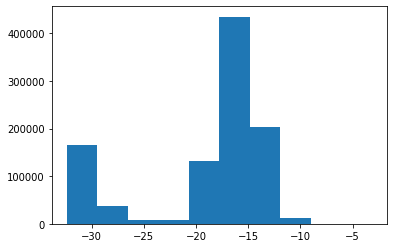

In [10]:
plt.hist(hv_bands[0].ravel())

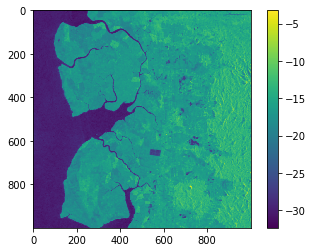

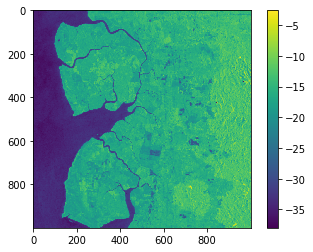

In [11]:
for k, hv in enumerate(hv_bands):
    if k in [INDEX_FIRST, INDEX_LAST]:
        plt.figure()
        plt.imshow(hv)
        plt.colorbar()

# Remove Non-mangrove Areas

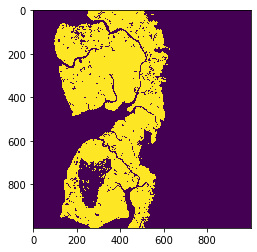

In [12]:
with rasterio.open(mangrove_extent) as ds:
    mangrove_mask = ds.read(1).astype(bool)
    
plt.imshow(mangrove_mask)

In [13]:
def remove_non_mangrove(band):
    band_new = band.copy()
    band_new[~mangrove_mask] = np.nan
    return band_new

hv_bands_mangrove_only = list(map(remove_non_mangrove, hv_bands))

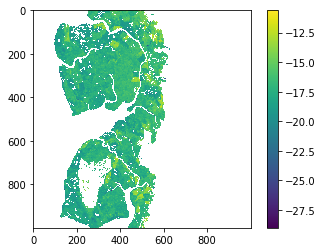

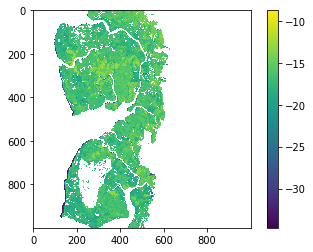

In [14]:
for k, hv in enumerate(hv_bands_mangrove_only):
    if k in [INDEX_FIRST, INDEX_LAST]:
        plt.figure()
        plt.imshow(hv)
        plt.colorbar()

## Visualize Pair (Take 1)

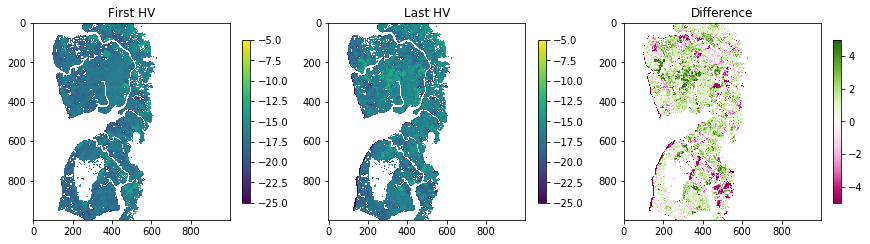

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(15, 10))

im = ax[0].imshow(hv_bands_mangrove_only[INDEX_FIRST], vmin=-25, vmax=-5)
ax[0].set_title('First HV')
fig.colorbar(im, ax=ax[0], shrink=.3)


im = ax[1].imshow(hv_bands_mangrove_only[INDEX_LAST], vmin=-25, vmax=-5)
ax[1].set_title('Last HV')
fig.colorbar(im, ax=ax[1], shrink=.3)

diff_hv = hv_bands_mangrove_only[INDEX_LAST] - hv_bands_mangrove_only[INDEX_FIRST]

ax[2].set_title('Difference')
im = ax[2].imshow(diff_hv, vmin=-5, vmax=5, cmap='PiYG')
fig.colorbar(im, ax=ax[2], shrink=.3)

# Noramlizing Statistics

Because the imagery was acquired on different days with different environmental conditions, we expect that on average our scene should possess roughly the same statistics (normally distributed).

We normalize the statistics in the second scene to match those in the first.

In [16]:
def normalize_statistics(band, mu_new, sigma_new):
    arr_new = (band - np.nanmean(band)) / np.nanstd(band) * sigma_new + mu_new
    return arr_new

In [17]:
pair = [hv_bands_mangrove_only[INDEX_FIRST], hv_bands_mangrove_only[INDEX_LAST]]

mu_first = np.nanmean(pair[0])
sigma_first = np.nanstd(pair[0])

pair[1] = normalize_statistics(pair[1], mu_first, sigma_first)
diff_hv = pair[1] - pair[0]

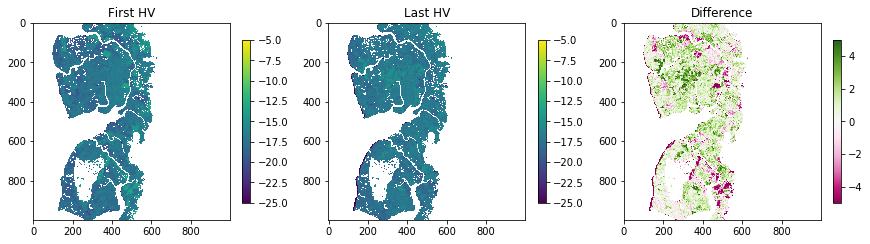

In [18]:
fig, ax = plt.subplots(1, 3, figsize=(15, 10))

im = ax[0].imshow(pair[0], vmin=-25, vmax=-5)
ax[0].set_title('First HV')
fig.colorbar(im, ax=ax[0], shrink=.3)


im = ax[1].imshow(pair[1], vmin=-25, vmax=-5)
ax[1].set_title('Last HV')
fig.colorbar(im, ax=ax[1], shrink=.3)

diff_hv = hv_bands_mangrove_only[INDEX_LAST] - hv_bands_mangrove_only[INDEX_FIRST]

ax[2].set_title('Difference')
im = ax[2].imshow(diff_hv, vmin=-5, vmax=5, cmap='PiYG')
fig.colorbar(im, ax=ax[2], shrink=.3)

Let's write this pair to a tif file for later reference.

In [19]:
p_pair = profile.copy()
p_pair['nodata'] = np.nan

def write_one_band(band, dest_path):
    # profile from above
    with rasterio.open(dest_path, 'w', **p_pair) as ds:
        ds.write(band, 1)
    return dest_path

In [20]:
from itertools import starmap

dest_dir = out_dir/f'pair_data'
dest_dir.mkdir(exist_ok=True, parents=True)
dest_paths = [dest_dir/f'hv_{k}.tif' for k in range(2)] + [dest_dir/f'diff_{INDEX_FIRST}{INDEX_LAST}.tif']

bands_to_write = pair + [diff_hv]

list(starmap(write_one_band, zip(bands_to_write, dest_paths)))

[PosixPath('1_change_detection/Pair_06/pair_data/hv_0.tif'),
 PosixPath('1_change_detection/Pair_06/pair_data/hv_1.tif'),
 PosixPath('1_change_detection/Pair_06/pair_data/diff_06.tif')]

# The Nodata Mask

This is really important and annoying. The nodata is everwhere in our scene that is non-mangrove.

This type of bookkeeping is important for effective remote sensing analysis.

In [21]:
nan_mask = np.isnan(pair[0])

# Change Detection from the Difference Map

Typically, the volumetric decrease measured by HV denotes some type of forest loss.


## Loss - HV decrease

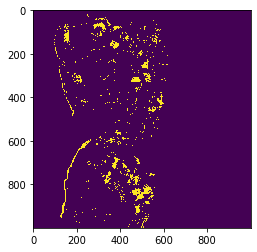

In [22]:
change_areas = np.zeros(nan_mask.shape)
change_areas[~nan_mask] = diff_hv[~nan_mask] < -2

plt.imshow(change_areas)

We can experiment with a range of thresholds from `2` to `4` db.

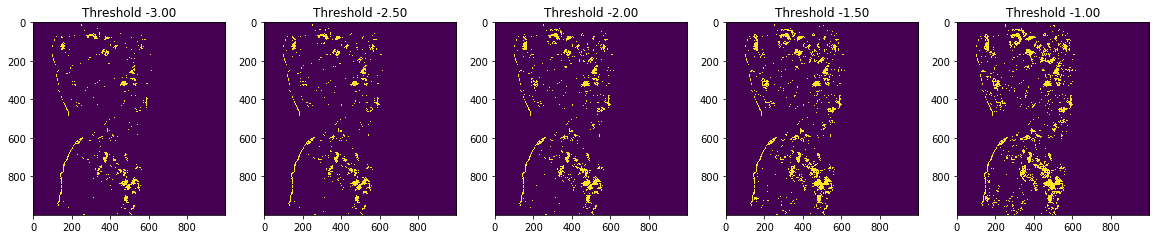

In [23]:

thresholds = np.linspace(-3, -1, 5)
N = len(thresholds)

fig, axs = plt.subplots(1, N, figsize=(20, 10))

for (ax, t) in zip(axs.ravel(), thresholds):
    change_areas = np.zeros(nan_mask.shape)
    change_areas[~nan_mask] = diff_hv[~nan_mask] < t
    ax.imshow(change_areas.astype(int))
    ax.set_title(f'Threshold {t:1.2f}')

## Morphological Filtering

We see there are lots of small areas where we detected change. This could be the residual noise in the image or just small environmental changes in the mangrove forest.

We can filter these detected change areas by size. Specifically, we segment a binary array into contiguous parts using [`label`](https://docs.scipy.org/doc/scipy-0.16.0/reference/generated/scipy.ndimage.measurements.label.html#scipy.ndimage.measurements.label) and then measure each segments size. Using these labels and size, we only consider change areas of a specific size.

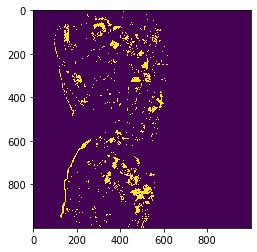

In [24]:
loss_areas = np.zeros(nan_mask.shape)
loss_areas[~nan_mask] = (diff_hv[~nan_mask]) < -1.5

plt.imshow(loss_areas)

Below, we filter those areas that are less than 50 pixels. The resolution we have is about 25 meters, so this translates to .25 hectares.

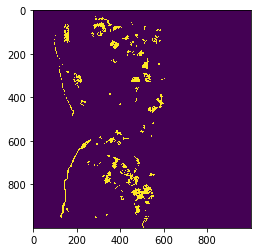

In [25]:
loss_areas_filtered = filter_binary_array_by_min_size(loss_areas, 50)

plt.imshow(loss_areas_filtered)

We remark those decreases on the coast are not changes in mangrove but likely geocoding errors from the 

In [26]:
polygonize_array_to_shapefile(loss_areas_filtered, 
                              profile, 
                              out_dir/f'loss_from_hv_threshold_{INDEX_FIRST}{INDEX_LAST}', 
                              mask=~(loss_areas_filtered.astype(bool)))

## Large Gain - HV Increase

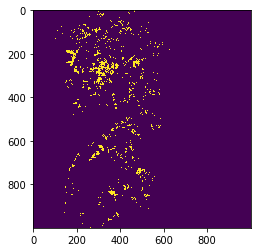

In [27]:
change_areas = np.zeros(nan_mask.shape)
change_areas[~nan_mask] = diff_hv[~nan_mask] > 3

plt.imshow(change_areas)

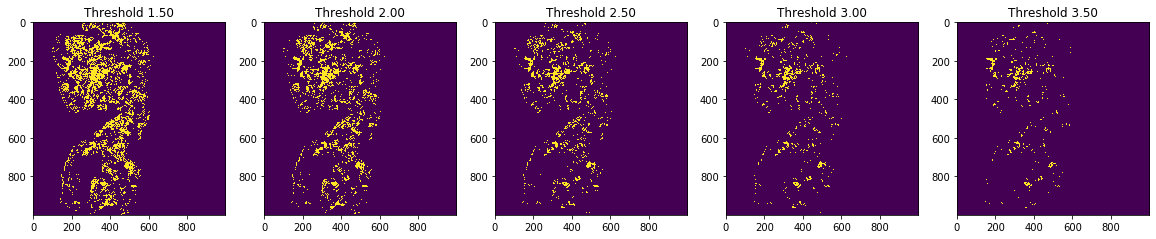

In [28]:
thresholds = np.linspace(1.5, 3.5, 5)
N = len(thresholds)

fig, axs = plt.subplots(1, N, figsize=(20, 10))

for (ax, t) in zip(axs.ravel(), thresholds):
    change_areas = np.zeros(nan_mask.shape)
    change_areas[~nan_mask] = diff_hv[~nan_mask] > t
    ax.imshow(change_areas.astype(int))
    ax.set_title(f'Threshold {t:1.2f}')

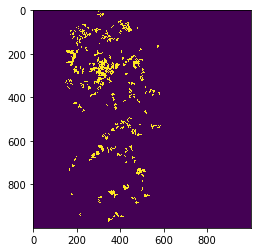

In [29]:
gain_areas = np.zeros(nan_mask.shape)
gain_areas[~nan_mask] = (diff_hv[~nan_mask]) > 2.5

gain_areas_filtered = filter_binary_array_by_min_size(gain_areas, 50)


plt.imshow(gain_areas_filtered)

In [30]:
polygonize_array_to_shapefile(gain_areas_filtered, 
                              profile, 
                              out_dir/f'gain_from_hv_threshold_{INDEX_FIRST}{INDEX_LAST}', 
                              mask=~(gain_areas_filtered.astype(bool)))

# Note

Now that you have your changed areas as shapefiles you can view them in [Google Earth Pro](https://www.google.com/earth/versions/) and use the time lapse functionality (demonstrated [here](https://www.youtube.com/watch?v=fxJe03ubfbw)) to validate these areas using very high resolution imagery.

# Acknowledgements

This tutorial was written by Charlie Marshak and supervised closely by [Marc Simard](https://scholar.google.com/citations?user=JQJF1wgAAAAJ&hl=en). 

This tutorial was for the 2019 SARI training [conference](http://sari.umd.edu/meetings/international-regional-science-training) held at Prince of Songkla University, Phuket Campus. We are grateful to the conference organizers [Krishna Vadrevu](https://geog.umd.edu/facultyprofile/vadrevu/krishna) and [Werapong Koedsin](http://werapong-g.space.psu.ac.th/). We also thank the [SARI](http://sari.umd.edu/) and [LCLUC](https://lcluc.umd.edu/) programs, especially [Garik Gutman](https://lcluc.umd.edu/people/garik-gutman), making such trainings possible. We are grateful for the input from and helpful conversations with [Michael Denbina](https://www.researchgate.net/profile/Michael_Denbina), [Tien-Hao Liao](https://scienceandtechnology.jpl.nasa.gov/tien-hao-liao), and Neda Kasraee. 

We gratefully and humbly acknowledge JAXA for the use of ALOS-2 data to generate a coherence image over Mondah, Gabon generated using ISCE2. We are also grateful to the ASF for providing easy access to ALOS-1 radiometrically and terrain corrected tiles over Mondah and Ko Panyi.

A portion of this research was performed at the Jet Propulsion Laboratory, California Institute of Technology. 

Copyright 2019 by the California Institute of Technology. ALL RIGHTS RESERVED. United States Government Sponsorship acknowledged. Any commercial use must be negotiated with the Office of Technology Transfer at the California Institute of Technology.

This software may be subject to U.S. export control laws. By accepting this software, the user agrees to comply with all applicable U.S. export laws and regulations. User has the responsibility to obtain export licenses, or other export authority as may be required before exporting such information to foreign countries or providing access to foreign persons.
